<a href="https://colab.research.google.com/github/L22AR5N/Water-_level-_prediction_raindragon/blob/main/jang_LSTM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time

import tensorflow as tf
import tensorflow.keras.callbacks as callbacks
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='HCR Dotum')
# import warnings
# warnings.filterwarnings("ignore")
# tf.set_random_seed(777)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from datetime import datetime
import joblib

In [ ]:
###################################
# System Config
###################################

# start_time = pd.to_datetime('2020-08-01 00:00:00')
# end_time = pd.to_datetime('2020-08-14 23:00:00')

daeam = ['set_date', '방류량합계', '시간강우', '비룡수위']


# default train size rate
trainSize_rate = 0.6  # 학습 및 예측 셋 구분
current_time = datetime.today().strftime("%Y%m%d_%H%M%S")

seqLength = 6  # window size,  시퀀스 길이 : 과거 데이터 길이
hiddenDim = 10  # hiddenUnit 수
outputDim = 1  # output
# lr = 0.0001  # 학습률
drop_rate = 0.3  # Layer를 통과하여 생성된 파라메터의 수를 조정해주는 비율
target = 5  # 예측할 시간(0: 1시간, 2: 3시간, 5: 6시간)  -> 6 - 1시간, 12 - 2시간, 18 -3시간, 24 -4시간 30 - 5시간

model_list = ["GBM","RF","LSTM"]   # 분석 모델 리스트 설정 : LSTM, GBM, RF
performance_list = ["RMSE", "R2", "MSE"]    # 분석 성능평가 리스트 설정 : RMSE, R2, MSE, MAE


In [ ]:
# callsback 설정
# Early Stopping, ModelCheckpoint 설정
# Early Stopping : 모델의 학습이 더이상 진전이 없으면 학습을 종료j
# ModelCheckpoint : 모델 학습 중 학습이 잘되어진 모델을 계속해서 저장
cbs = [callbacks.EarlyStopping(monitor='val_loss',
                               patience=10,
                               mode='min'),
       # callbacks.ModelCheckpoint(filepath='bestModel.h5',
       #                           monitor='val_loss',
       #                           mode='min',
       #                           save_best_only=True)
       ]

In [ ]:
# def1 : data extraction

# Date 형 변환
def set_date(rawframe):
    rawframe['set_date'] = pd.to_datetime(rawframe[rawframe.columns[0]], format='%Y%m%d %H:%M', errors='coerce')
    rawframe = rawframe.drop(rawframe.columns[0], axis=1)
    return rawframe


In [ ]:
# DataFrame merge
def set_merge(tb1, tb2):
    raw_return = pd.merge(tb1, tb2, how='outer', on='set_date')
    return raw_return

In [ ]:
# 데이터 결측 범위 지정 결측값 도출
def set_outlier(df1):
    columns = list(range(1, df1.shape[1]))
    for i in columns:
        df1[df1.columns[i]].mask(
            (df1[df1.columns[i]] >= 16000) | (df1[df1.columns[i]] < -30), inplace=True)
    return df1

In [ ]:
# 입출력 자료 통합차트
def total_chart(df1, list1):
    columns = list(range(1, len(list1)))
    i = 1
    values = df1.values
    plt.figure(figsize=(9, 40))
    for variable in columns:
        plt.subplot(len(columns), 1, i)
        plt.plot(values[:, variable])
        plt.title(df1.columns[variable], y=0.5, loc='right')
        i += 1
    plt.show()

In [ ]:
#  기본 차트 : 이미지 저장용
def basic_chart(obsY, preY, str_part):
    if str_part == 'line':
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range(len(preY)), preY, '-x', label="predict Y")
        ax.plot(range(len(obsY)), obsY, '-', label="Original Y")
    plt.legend(loc='upper right')

In [ ]:
# RandomForest Regression Algorithm
def AL_RandomForest(trainX, trainY, testX, testY):
    rf_clf = RandomForestRegressor(n_estimators=100, random_state=15)
    rf_clf.fit(trainX, np.ravel(trainY, order="C"))
    # joblib.dump(rf_clf, )

    # relation_square = rf_clf.score(trainX, trainY)
    # print('RandomForest 학습 결정계수 : ', relation_square)

    y_pred1 = rf_clf.predict(trainX)
    y_pred2 = rf_clf.predict(testX)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(range(len(testY)), testY, '-', label="Original Y")
    # ax.plot(range(len(y_pred2)), y_pred2, '-x', label="predict Y")
    # plt.legend(loc='upper right')
    # plt.show()

    return rf_clf, y_pred2

In [ ]:
# GBR(GradientBoostingRegression) Algorithm
def AL_GradientBoosting(trainX, trainY, testX, testY):

    trainX.columns = pd.RangeIndex(trainX.shape[1])
    testX.columns = pd.RangeIndex(testX.shape[1])

    gbr_model = GradientBoostingRegressor(n_estimators=100, max_depth=3)
    gbr_model.fit(trainX, np.ravel(trainY, order="C"))

    y_pred = gbr_model.predict(trainX)
    y_pred2 = gbr_model.predict(testX)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(range(len(testY)), testY, '-', label="Original Y")
    # ax.plot(range(len(y_pred2)), y_pred2, '-x', label="predict Y")
    # plt.legend(loc='upper right')
    # plt.show()

    return gbr_model, y_pred2

In [ ]:
# XGBoosting Algorithm
def AL_XGBoosting(trainX, trainY, testX, testY):

    trainX.columns = pd.RangeIndex(trainX.shape[1])
    testX.columns = pd.RangeIndex(testX.shape[1])

    xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, max_depth=3)
    xgb_model.fit(trainX, np.ravel(trainY, order="C"))

    y_pred = xgb_model.predict(trainX)
    y_pred2 = xgb_model.predict(testX)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(range(len(testY)), testY, '-', label="Original Y")
    # ax.plot(range(len(y_pred2)), y_pred2, '-x', label="predict Y")
    # plt.legend(loc='upper right')
    # plt.show()

    return y_pred2

In [ ]:
# LSTM Algorithm
def AL_LSTM(trainX, trainY, testX, testY):
    # 모델 트레이닝
    model = keras.Sequential()
    # , activation='tanh'
    model.add(tf.keras.layers.Bidirectional(layers.LSTM(hiddenDim, return_sequences=True),
                                            input_shape=[seqLength, dataDim]))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Bidirectional(layers.LSTM(10)))
    model.add(layers.Dense(1))

    # optimizer 설정
    # opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8)  # replace "lr" with "learning_rate"
    # opt = optimizers.Adam(lr=lr)
    opt = keras.optimizers.Adam(learning_rate=0.0001)

    # 모델 학습과정 설정
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])

    # 모델 학습습
    his = model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=0,
                    validation_split=0.2,
                    callbacks=cbs)

    # 모델 테스트
    y_pred = model.predict(trainX)
    y_pred2 = model.predict(testX)

    return model, y_pred2

In [ ]:
# 알고리즘 실행 성능지표 함수
def Performance_index(obs, pre, mod_str):
    if mod_str == 'R2':
        pf_index = r2_score(obs, pre)
    elif mod_str == 'RMSE':
        s1 =  mean_squared_error(obs, pre)
        pf_index = np.sqrt(s1)
    elif mod_str == 'MSE':
        pf_index = mean_squared_error(obs, pre)
    elif mod_str == 'MAE':
        pf_index = mean_absolute_error(obs, pre)

    return pf_index

In [ ]:
# 정규화 함수
def MinMaxScaler(data):
    denom = np.max(data, 0) - np.min(data, 0)
    nume = data - np.min(data, 0)
    return nume / denom

In [ ]:
# 정규화 되돌리기 함수
def back_MinMax(data, value):
    diff = np.max(data, 0) - np.min(data, 0)
    back = value * diff + np.min(data, 0)
    return back

In [ ]:
# 각 지점의 알맞는 학습 배치 데이터 생성 함수
def buildDataSet(timeSeries, seqLength, target):
    xdata = []
    ydata = []
    for i in range(0, len(timeSeries) - seqLength - target):
        tx = timeSeries[i:i + seqLength]
        # print(tx)
        ty = timeSeries.iloc[i + seqLength + target, -1]
        # print(ty)
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [ ]:
# 각 지점의 알맞는 학습 배치 데이터 생성 함수
def buildDataSet2(timeSeries, seqLength, target):
    xdata = pd.DataFrame()
    # ydata = pd.DataFrame()
    for s in range(0, seqLength):
        tx = timeSeries.iloc[(seqLength - s):(len(timeSeries) - s - target), :].reset_index()
        xdata = pd.concat([xdata, tx], axis=1, ignore_index=False)

    xdata = xdata.drop(['index'], axis='columns')
    ydata = timeSeries.iloc[seqLength + target:, -1]
    return xdata, ydata

In [ ]:
def makeDir(model):
    path_result_data = "./result_data/" + current_time + "/" + model + "/"
    if not os.path.isdir(path_result_data):
        os.makedirs(path_result_data)
    path_result_graph = "./result_graph/" + current_time + "/" + model + "/"
    if not os.path.isdir(path_result_graph):
        os.makedirs(path_result_graph)
    path_result_model = "./result_model/" + current_time + "/" + model + "/"
    if not os.path.isdir(path_result_model):
        os.makedirs(path_result_model)

    path_list = pd.DataFrame([(path_result_data, path_result_graph, path_result_model)], columns=['data','graph','model'])
    return path_list

In [ ]:
###################################
print("Modulation 1 : 데이터 전처리")
###################################
# 추후 3개의 csv로 적용
# raw_flood1 = pd.read_csv('/content/drive/MyDrive/jang/raindragon.csv', sep=',', encoding='ISO-8859-1')
raw_flood1 = pd.read_csv('/content/drive/MyDrive/jang/raindragon_ch_2.csv', sep=',', encoding='CP949')
raw_flood2 = set_date(raw_flood1)

# raw_flood2 = pd.read_csv('/content/drive/MyDrive/jang/taehwa.csv', sep=',', encoding='CP949')
# raw_flood2 = set_date(raw_flood2)

# raw_rainfall = pd.read_csv('/content/drive/MyDrive/jang/rainfall.csv', sep=',', encoding='CP949')
# raw_rainfall = set_date(raw_rainfall)

# raw_tidal = pd.read_csv('/content/drive/MyDrive/jang/tidal.csv', sep=',', encoding='CP949')
# raw_tidal = set_date(raw_tidal)

# raw_timeset = pd.DataFrame(pd.date_range(start_time, end_time, freq='H'))
# raw_timeset.columns = ['set_date']

Modulation 1 : 데이터 전처리


In [ ]:
print(raw_flood1.shape)
print(raw_flood1.head)

(2011, 4)
<bound method NDFrame.head of                 set_date    방류량합계  시간강우  비룡수위
0    2020-08-01 00:00:00   55.400   0.0  0.43
1    2020-08-01 00:10:00   55.400   0.0  0.43
2    2020-08-01 00:20:00   55.256   0.2  0.43
3    2020-08-01 00:30:00   55.184   0.2  0.43
4    2020-08-01 00:40:00   55.016   0.0  0.43
...                  ...      ...   ...   ...
2006 2020-08-14 02:20:00  435.231   0.0  1.73
2007 2020-08-14 02:30:00  437.645   0.0  1.72
2008 2020-08-14 02:40:00  438.064   0.0  1.72
2009 2020-08-14 02:50:00  440.882   0.0  1.70
2010 2020-08-14 03:00:00  443.175   0.0  1.69

[2011 rows x 4 columns]>


In [ ]:
# temp_list = [temp_daeam, temp_sayeon, temp_guyoung, temp_samho, temp_taewha]
# temp_list_name = ["daeam", "sayeon", "guyoung", "samho", "taewha"]

temp_list = [raw_flood1]
temp_list_name = ["daeam"]

# temp_list = [raw_flood1]
# temp_list_name = ["daeam"]

model :  GBM


findfont: Font family ['HCR Dotum'] not found. Falling back to DejaVu Sans.
findfont: Font family ['HCR Dotum'] not found. Falling back to DejaVu Sans.


daeam GBM 예측 RMSE :  0.03885398291221921
daeam GBM 예측 R2 :  0.9998404638003026
daeam GBM 예측 MSE :  0.0015096319881430227
GBM , time : 0.5686149597167969
model :  RF
daeam RF 예측 RMSE :  0.08463058291904495
daeam RF 예측 R2 :  0.9992430924847864
daeam RF 예측 MSE :  0.007162335565217342
RF , time : 0.8550505638122559
model :  LSTM
daeam LSTM 예측 RMSE :  0.8327812776604536
daeam LSTM 예측 R2 :  0.9267090993361387
daeam LSTM 예측 MSE :  0.6935246564217775
LSTM , time : 54.94796442985535


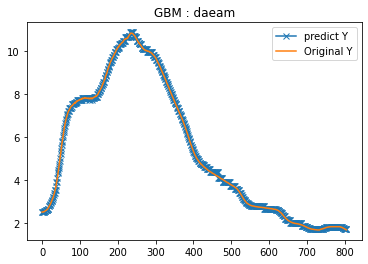

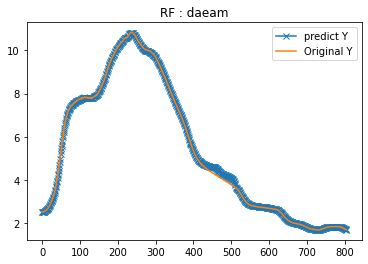

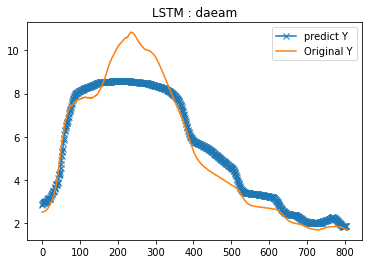

In [ ]:
# def run():
  ###################################
  # 각 지점마다 모델 생성 및 학습
  ###################################
# target_list = [0,5,11,29]  # 0 : 그 다음것 예측 10분인것, 6 : 7번째 예측 : 70분후
target_list = [0] # 10분 예측
for t in target_list:
    for md in model_list:
        print("=" * 30)
        print("model : ", md)
        print("=" * 30)
        count = 0

        start = time.time()  # 시작 시간 저장
        for df in temp_list:
            """
            Modulation 2 : 학습데이터 정제
            """
            # print("Modulation 2 : 학습데이터 정제")
            # 날짜 데이터를 제외한 나머지 값
            # xy = df.drop(['set_date'], axis='columns')
            xy = df.drop(['set_date'], axis='columns')

            dataDim = len(xy.columns)  # 매개변수의 개수

            # train셋과 test셋을 분류(0.8 비율)
            trainSize = int(len(xy) * trainSize_rate)
            trainSet = xy[0:trainSize]
            testSet = xy[trainSize - seqLength:]

            """
            Modulation 3 : 모델 학습
            """
            # print("Modulation 3 : 모델 학습")
            if md == "LSTM":
                # MinMaxScaler(trainSet)
                # MinMaxScaler(testSet)

                # 각 지점의 알맞는 학습 배치 데이터 생성
                trainX, trainY = buildDataSet(trainSet, seqLength, t)
                testX, testY = buildDataSet(testSet, seqLength, t)
                model, predict = AL_LSTM(trainX, trainY, testX, testY)

                # yhat = back_MinMax(xy[xy.columns[-1]], predict)
                # actual = back_MinMax(xy[xy.columns[-1]], testY)
                yhat = predict
                actual = testY

            else:
                if md == "GBM":
                    # 각 지점의 알맞는 학습 배치 데이터 생성
                    trainX, trainY = buildDataSet2(trainSet, seqLength, t)
                    testX, testY = buildDataSet2(testSet, seqLength, t)
                    model, predict = AL_GradientBoosting(trainX, trainY, testX, testY)
                elif md == "RF":
                    # 각 지점의 알맞는 학습 배치 데이터 생성
                    trainX, trainY = buildDataSet2(trainSet, seqLength, t)
                    testX, testY = buildDataSet2(testSet, seqLength, t)
                    model, predict = AL_RandomForest(trainX, trainY, testX, testY)

                yhat = predict
                actual = testY

            # 성과지표 표출 부분 : 적용 항목은 confing > performance_list[] 참조
            for pi in performance_list:
                rmse = Performance_index(actual, yhat, pi)
                print(temp_list_name[count] + " " + md + ' 예측 ' + pi + ' : ', rmse)

            # print(temp_list_name[count])
            # actual = actual.to_numpy()
            # tmp = actual - yhat
            # tmp = abs(tmp)
            # print(tmp)
            # exit(1)
            # print(type(actual))
            # print(type(yhat))
            # print("평균 :", np.mean(tmp))
            # print("분산 :", np.var(tmp))
            # print("표준편차 :", np.std(tmp))
            # exit(1)


            """
            Modulation 4 : 결과 데이터 저장
            """
            # print("Modulation 4 : 결과 데이터 저장")
            #
            dir_list = makeDir(md)
            # print("dir_list값 확인:",dir_list ,"pi:", pi , "rmse:", rmse)
            # print("#################################################################")
            # # # 복원된 데이터 저장
            pd_actual_save = pd.DataFrame(actual).reset_index()
            pd_actual_save.to_csv(dir_list['data'][0] + temp_list_name[count] + "_actual.csv", mode='w')

            pd_predict_save = pd.DataFrame(yhat).reset_index()
            pd_predict_save.to_csv(dir_list['data'][0] + temp_list_name[count] + ".csv", mode='w')
            #
            # 그래프 저장
            basic_chart(actual, yhat, 'line')
            plt.title(md + " : " + temp_list_name[count])
            plt.savefig(dir_list['graph'][0] + temp_list_name[count] + '.png')

            count += 1
        print(md, ", time :", time.time() - start)

# plt.show()


model :  GBM
daeam GBM 예측 RMSE :  0.04247837009267836
daeam GBM 예측 R2 :  0.999809311790171
daeam GBM 예측 MSE :  0.0018044119257305516
GBM , time : 0.5161445140838623
model :  RF
daeam RF 예측 RMSE :  0.08463058291904495
daeam RF 예측 R2 :  0.9992430924847864
daeam RF 예측 MSE :  0.007162335565217342
RF , time : 0.8741052150726318
model :  LSTM
daeam LSTM 예측 RMSE :  1.630347555320487
daeam LSTM 예측 R2 :  0.7191020653158462
daeam LSTM 예측 MSE :  2.658033151139488
LSTM , time : 26.786386251449585
model :  GBM
daeam GBM 예측 RMSE :  0.2894365212940243
daeam GBM 예측 R2 :  0.9911546689778551
daeam GBM 예측 MSE :  0.0837734998587862
GBM , time : 0.5224273204803467
model :  RF
daeam RF 예측 RMSE :  0.3125482898889381
daeam RF 예측 R2 :  0.9896856542671926
daeam RF 예측 MSE :  0.0976864335124997
RF , time : 0.8852720260620117
model :  LSTM
daeam LSTM 예측 RMSE :  2.1629994637731818
daeam LSTM 예측 R2 :  0.5060076149851667
daeam LSTM 예측 MSE :  4.6785666802830725
LSTM , time : 28.571238040924072
model :  GBM
daeam GBM 예

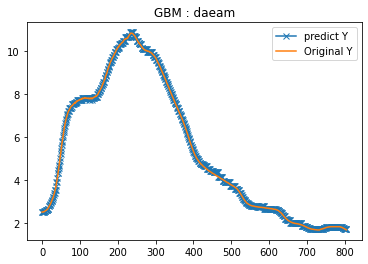

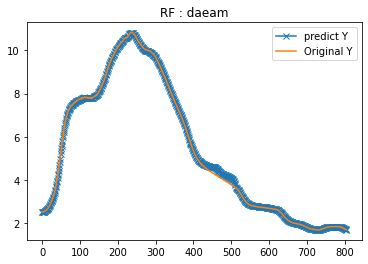

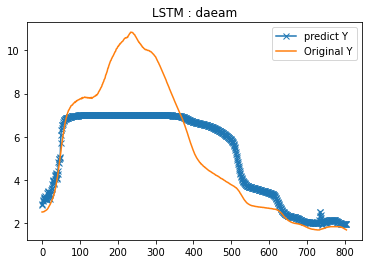

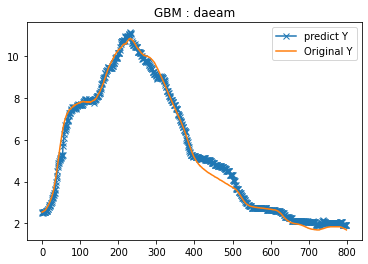

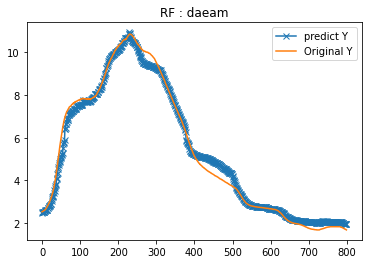

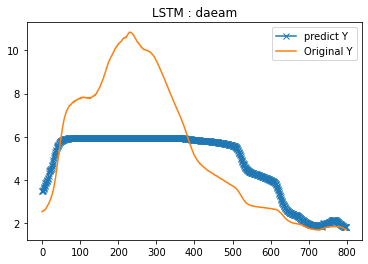

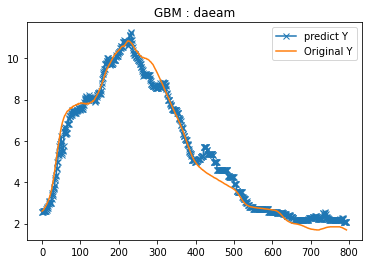

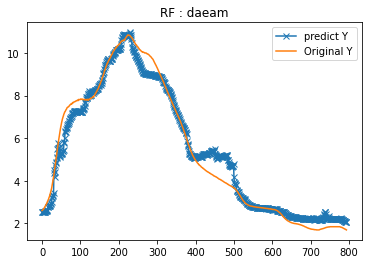

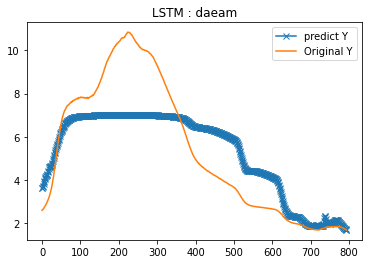

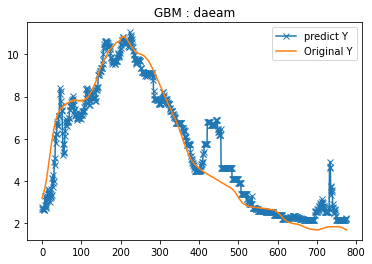

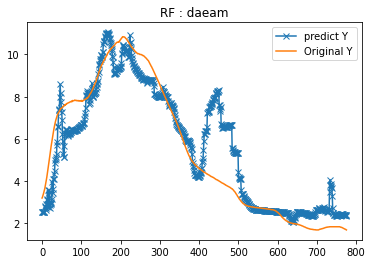

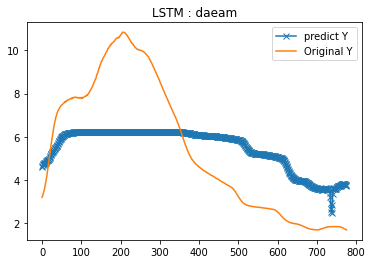

In [ ]:
#target_list = [0,5,11,29] -> 10분,1시간,2시간,5시간
# run()